In [1]:
%pylab inline
from clawpack.pyclaw import Solution
import os
import pygmt
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import cartopy

Populating the interactive namespace from numpy and matplotlib


In [62]:
def read_fortq(frame):
    """
    Import fort.q files to get x,y,z data
    """
    fortq = Solution(frame, file_format='ascii')
    patch_dict = {}
    for stateno, state in enumerate(fortq.states):
        patch = state.patch
        level = patch.level
        Xc, Yc = state.grid.c_centers
        h = state.q[0,:,:]
        eta = state.q[3,:,:]
        drytol_default = 0.00
        water = np.copy(eta)
        idx = np.where((h<=drytol_default) & (h>=-drytol_default))
        water[idx] = np.nan
#         idx2 = np.where(eta==0)
#         water[idx2] = np.nan
        
        # Save variables to dictionary
        long=Xc[:,0]
        lat = Yc[0]
        patch_dict[stateno] = {"lat": lat, 'long':long, 'eta':eta, 'amr_level':level, 'Xc':Xc, 'Yc':Yc, 'water':water}
    return patch_dict, water, h, Xc, Yc, eta

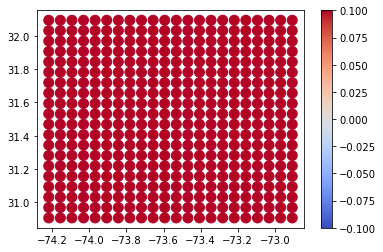

In [63]:
### Test plot of the data
### Seeing only the finest patch, not the largest which is why no details show up
for i in range(4,5):
    [patch_dict, water, h, X, Y, eta]=read_fortq(i)
    plt.figure()
    plt.scatter(X,Y,c=water,s=100,cmap=plt.get_cmap('coolwarm'))
    plt.clim(-0.1,0.10)
    plt.colorbar()
    plt.show()

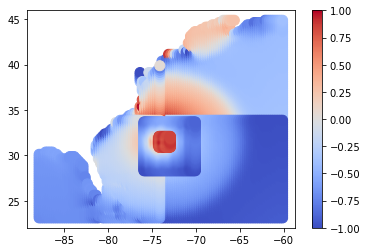

In [64]:
plt.figure()
for key in patch_dict:
    X = patch_dict[key]['Xc']
    Y = patch_dict[key]['Yc']
    water = patch_dict[key]['water']
    
    plt.scatter(X,Y,c=water, s=100, cmap=plt.get_cmap('coolwarm'))
plt.clim(-1.0, 1.0)
plt.colorbar()
plt.show()

0 34.125 44.875 -73.875 <built-in method max of numpy.ndarray object at 0x7ffc036a5490> 0.7689172479258559 0.9612834654690232
1 23.125 33.875 -73.875 <built-in method max of numpy.ndarray object at 0x7ffc036a54e0> 0.7689172479258559 0.9612834654690232
2 34.125 44.875 -87.875 <built-in method max of numpy.ndarray object at 0x7ffbe41efe40> 0.7689172479258559 0.9612834654690232
3 23.125 33.875 -87.875 <built-in method max of numpy.ndarray object at 0x7ffbe41ef990> 0.7689172479258559 0.9612834654690232
4 28.3125 33.6875 -75.9375 <built-in method max of numpy.ndarray object at 0x7ffbe41efc60> 0.7689172479258559 0.9612834654690232
5 30.90625 32.09375 -74.21875 <built-in method max of numpy.ndarray object at 0x7ffbe41ef300> 0.7689172479258559 0.9612834654690232


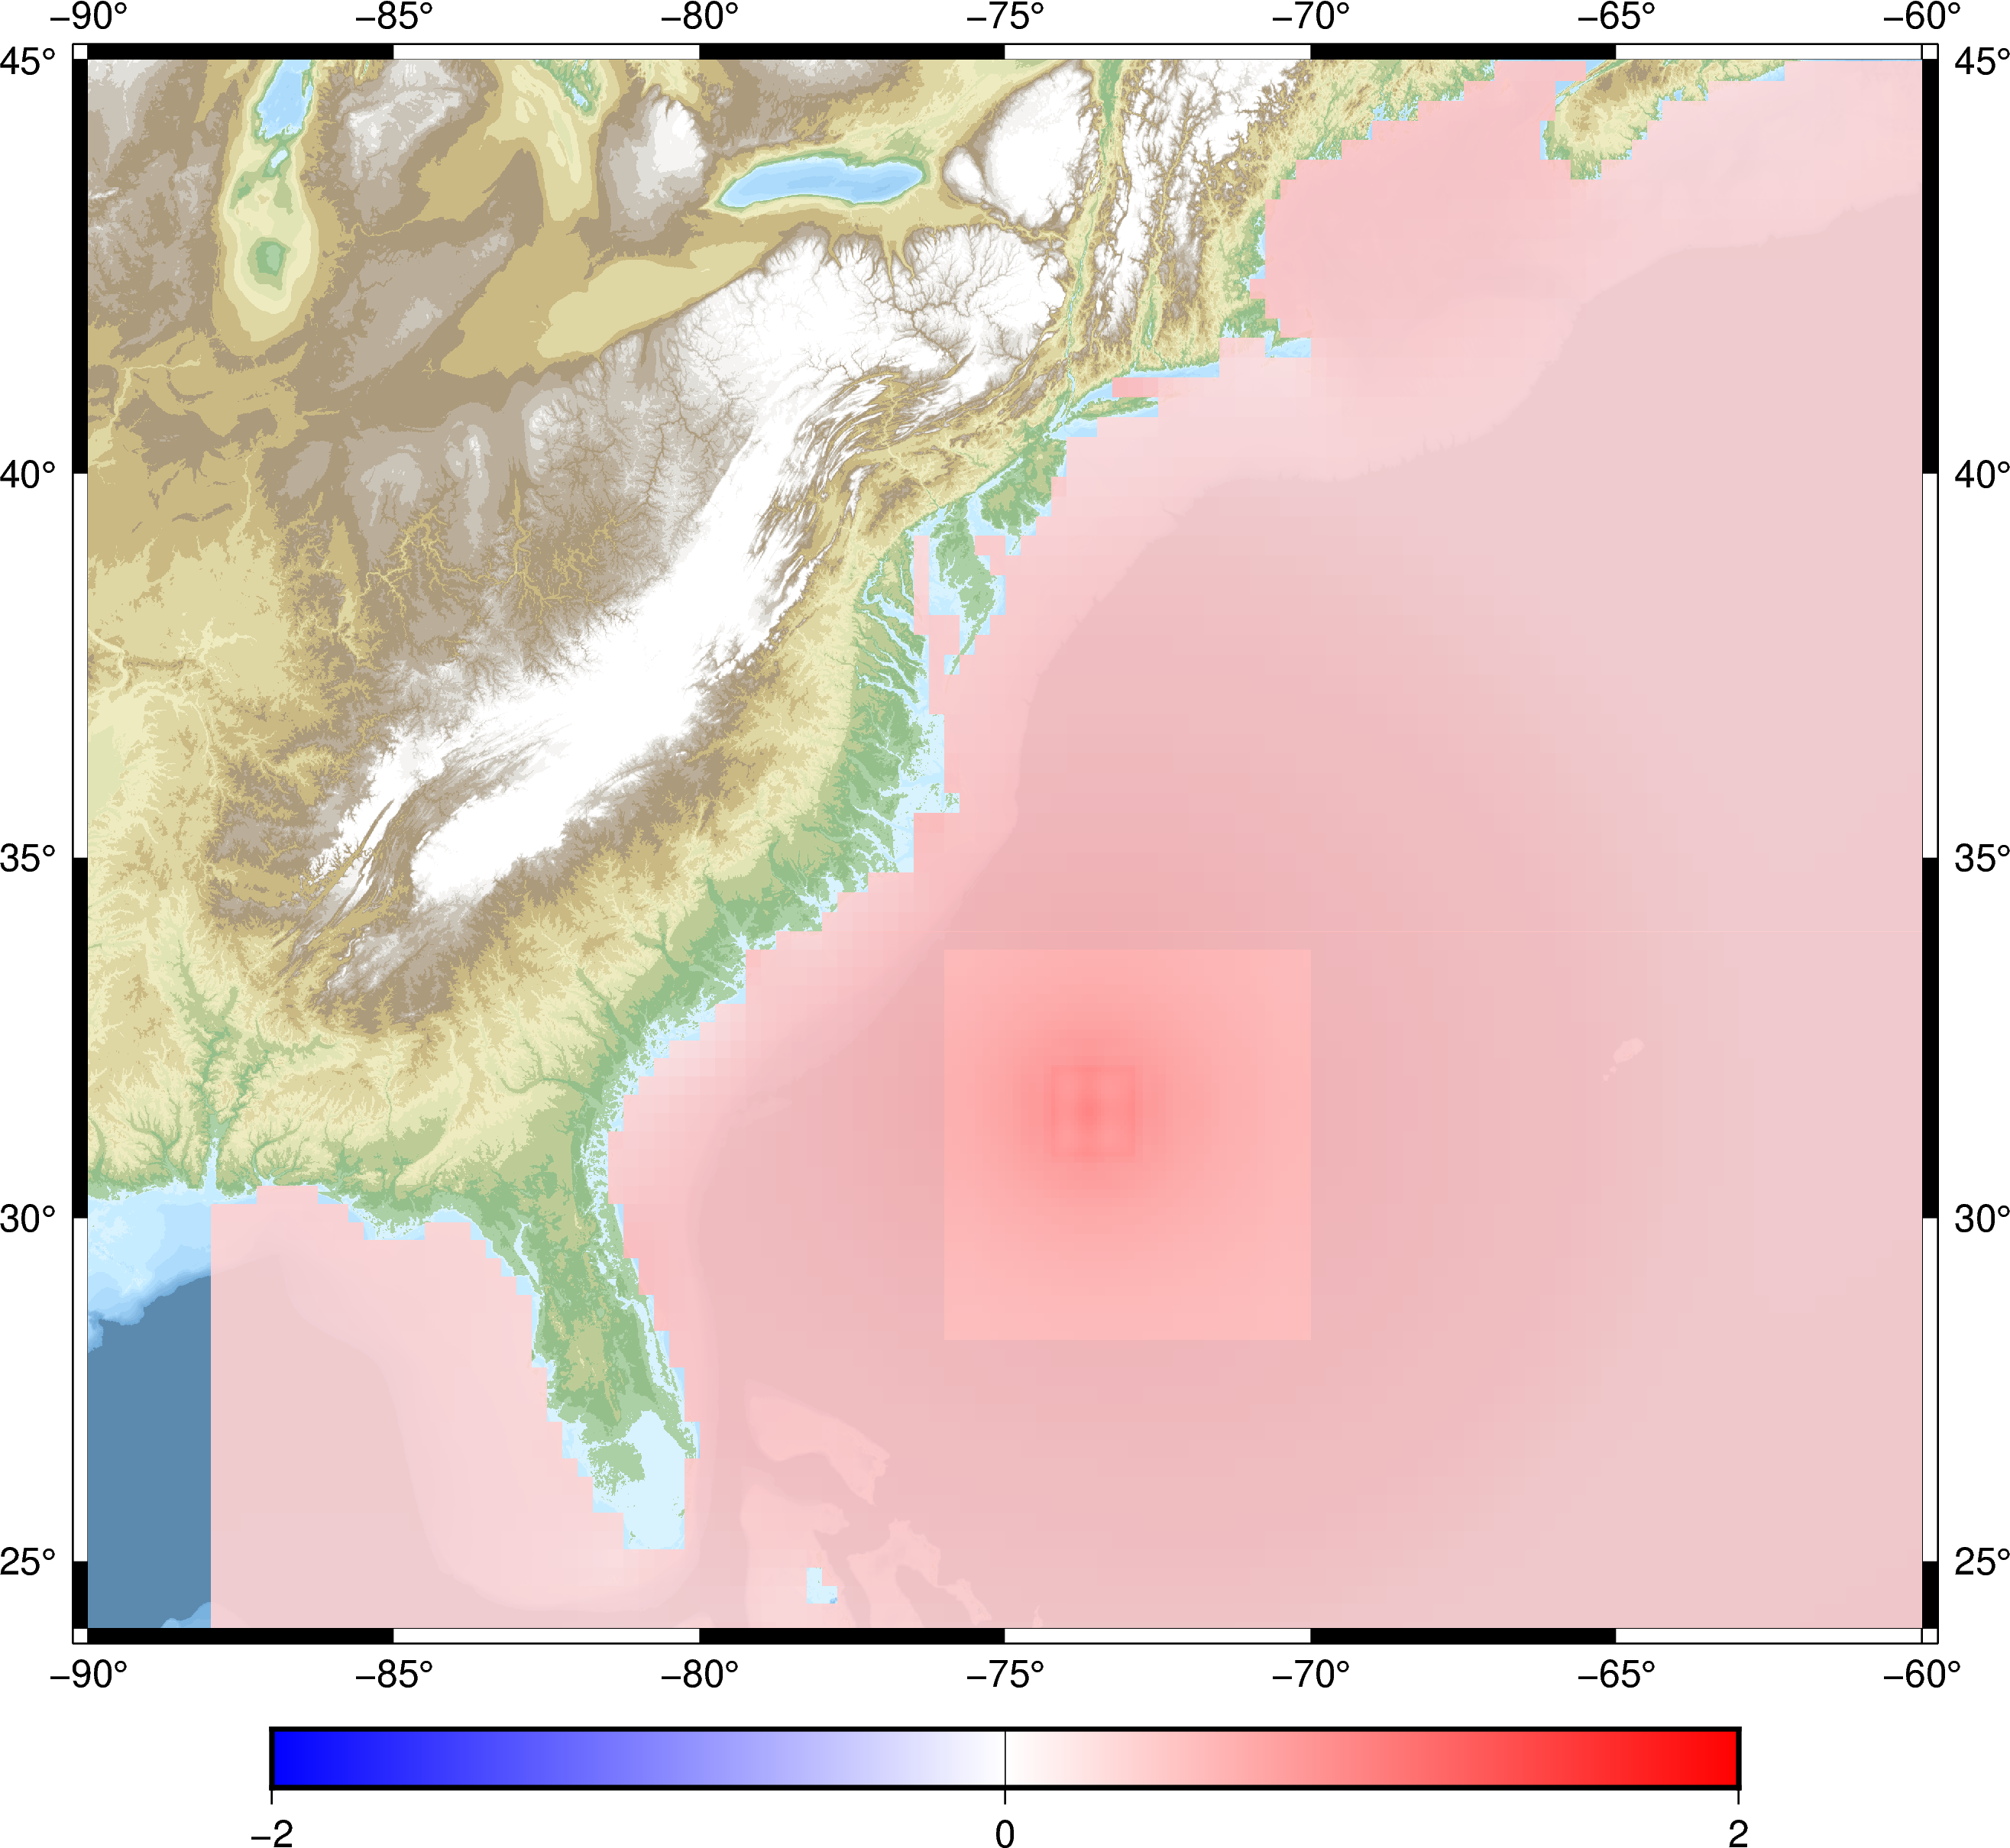

In [77]:
# def gmt_map(lat, lon, water):
bathy = '/mnt/c/RData/bathy/entire_world_srtm30.grd'
[patch_dict, water, h, X, Y, eta]=read_fortq(4)
fig = pygmt.Figure()
fig.basemap(region=[-90.0, -60.00, 24., 45.], projection='M8i',frame='a')
pygmt.makecpt(series=[-500, 500], cmap='wiki-france')
fig.grdimage(bathy,region=[-90.0, -60.00, 24., 45.] )
pygmt.makecpt(series=[-2, 2], cmap='polar')
# x = X[:,0]
# y = Y[0]
# df = pd.DataFrame(data=water, index=[i for i in x], columns=[j for j in y])
# df.index.name='Longitude'
# df.columns.name="Latitude"
# da=xr.DataArray(data=df.T)
for patch in patch_dict:
    lat = patch_dict[patch]['lat']
    long = patch_dict[patch]['long']
    water = patch_dict[patch]['water']
    if patch_dict[patch]['amr_level'] >= 1:
        print(patch, lat.min(), lat.max(), long.min(),long.max, eta.min(), eta.max())
        df = pd.DataFrame(data=water, index=[i for i in long], columns=[i for i in lat])# 'Latitude':lat, 'Longitude':long})
        df.index.name='Longitude'
        df.columns.name="Latitude"
        da=xr.DataArray(data=df.T)

        fig.grdimage(da, Q=True,t=10)
fig.colorbar()
fig.show()
### Plot GMT map


# gmt_map(X, Y, water)
 

In [78]:
water -= .33
water

array([[0.49964594, 0.49886538, 0.49788077, 0.50536582, 0.51291023,
        0.52364276, 0.53574222, 0.54716461, 0.55547144, 0.56013894,
        0.56114027, 0.55861215, 0.55322153, 0.54532186, 0.5370585 ,
        0.53055132, 0.52656839, 0.52268331, 0.52590262, 0.52597909],
       [0.48987785, 0.47957344, 0.4739097 , 0.47615326, 0.48048309,
        0.48943174, 0.5022359 , 0.5150351 , 0.52503758, 0.530668  ,
        0.53152972, 0.52816245, 0.52131668, 0.51238921, 0.50415057,
        0.50038061, 0.49940567, 0.49957515, 0.50779516, 0.51600071],
       [0.47821341, 0.46219802, 0.45208534, 0.44943739, 0.44995562,
        0.45720568, 0.47019264, 0.48394208, 0.49466016, 0.50050683,
        0.50107551, 0.49668728, 0.4886225 , 0.4785815 , 0.4705037 ,
        0.46828244, 0.47109745, 0.47479184, 0.48712869, 0.50089599],
       [0.47931711, 0.4614746 , 0.44779007, 0.44243939, 0.44080631,
        0.4474275 , 0.46118819, 0.47643034, 0.48860058, 0.49527788,
        0.49581589, 0.49063168, 0.48127666, 0

fig = plt.figure(figsize=[20,15])
ax = fig.add_subplot(121, projection=ccrs.PlateCarree([-74, -60.00, 20., 44]))
img_extent = [-90, -60.00, 25., 44]

ax.set_extent(img_extent)
ax.coastlines()
for patch in patch_dict:
    lat = patch_dict[patch]['lat']
    long = patch_dict[patch]['long']
    water = patch_dict[patch]['water']
    if patch_dict[patch]['amr_level'] >= 1:
        df = pd.DataFrame(data=water, index=[i for i in long], columns=[i for i in lat])# 'Latitude':lat, 'Longitude':long})
        df.index.name='Longitude'
        df.columns.name="Latitude"
        da=xr.DataArray(data=df.T)
        X, Y = np.meshgrid(lat, long)
        ax.contourf(X, Y, water)


# import numpy as np
# lon = np.linspace(-80, 80, 25)
# lat = np.linspace(30, 70, 25)
# lon2d, lat2d = np.meshgrid(lon, lat)
# data = np.cos(np.deg2rad(lat2d) * 4) + np.sin(np.deg2rad(lon2d) * 4)
# ax.contourf(da, alpha=0.5)
plt.show()

# fig = plt.figure(2)
# plt.pcolor(Xc, Yc, eta, vmin=-0.1, vmax=1.)

In [13]:
ccrs.Geodetic?

{0: {'lat': array([34.125, 34.375, 34.625, 34.875, 35.125, 35.375, 35.625, 35.875,
         36.125, 36.375, 36.625, 36.875, 37.125, 37.375, 37.625, 37.875,
         38.125, 38.375, 38.625, 38.875, 39.125, 39.375, 39.625, 39.875,
         40.125, 40.375, 40.625, 40.875, 41.125, 41.375, 41.625, 41.875,
         42.125, 42.375, 42.625, 42.875, 43.125, 43.375, 43.625, 43.875,
         44.125, 44.375, 44.625, 44.875]),
  'long': array([-73.875, -73.625, -73.375, -73.125, -72.875, -72.625, -72.375,
         -72.125, -71.875, -71.625, -71.375, -71.125, -70.875, -70.625,
         -70.375, -70.125, -69.875, -69.625, -69.375, -69.125, -68.875,
         -68.625, -68.375, -68.125, -67.875, -67.625, -67.375, -67.125,
         -66.875, -66.625, -66.375, -66.125, -65.875, -65.625, -65.375,
         -65.125, -64.875, -64.625, -64.375, -64.125, -63.875, -63.625,
         -63.375, -63.125, -62.875, -62.625, -62.375, -62.125, -61.875,
         -61.625, -61.375, -61.125, -60.875, -60.625, -60.375, -60.125